# Imports

In [22]:
#!pip install numpy-stl

In [24]:
#!pip install -U scikit-learn


In [25]:
#!pip install vtkplotlib

In [4]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [5]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [6]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [7]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [8]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [9]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[20.25005186 20.25526691 20.25010239 ...  6.36173748 18.25531576
  6.36281297]
[19.80543703 19.81053757 19.80548644 ...  6.22205769 17.85449781
  6.22310958]
[1.         1.         1.         ... 0.99819377 0.99999999 0.99819569]
(5999,)


### Multinomial Sampling

In [10]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[0 0 0 ... 0 0 0]


In [11]:
target_number_point = min(len(graph._node), 50)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(91.42513, 0.33300498, -2.505017), (82.27729, 8.672658, -3.4772909), (81.886826, 8.535009, 89.70452), (90.083786, -5.7970243, 0.593843), (90.74569, 4.1574683, -1.3160838), (77.49305, -6.5098743, 2.360639), (87.40501, -0.99710757, -8.605006), (76.407776, -7.328478, 0.13261138), (79.53464, 7.9794145, 1.4894849), (75.19, -1.8187612, 55.4), (75.23533, -7.6759295, 85.69034), (76.83378, -0.99710757, -13.647223), (78.052864, -7.328478, 83.672165), (75.57272, -8.535009, -7.1282763), (78.879944, -7.328478, 3.1854777), (79.18599, 8.672658, 90.60188), (77.85172, 8.237194, -1.13933), (85.16452, 2.3044074, -10.190267), (81.17586, -8.399635, 55.4), (81.04928, 8.672658, 89.526115), (51.0, 2.1432736, 81.46499), (82.27729, 8.672658, 88.47729), (75.91289, 1.6554987, 98.61897), (80.99978, 8.798424, -2.8634322), (83.60757, 8.348472, 88.95029), (75.0, -8.447791, -2.535284), (63.0, 5.670694, 83.27072), (75.86183, 3.8609922, 81.43093), (77.83952, -8.610001, -2.577679), (82.99811, 8.672658, 87.67674), (83.32

# KNN

In [12]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[91.42513, 0.33300498, -2.505017], [82.27729, 8.672658, -3.4772909], [81.886826, 8.535009, 89.70452], [90.083786, -5.7970243, 0.593843], [90.74569, 4.1574683, -1.3160838], [77.49305, -6.5098743, 2.360639], [87.40501, -0.99710757, -8.605006], [76.407776, -7.328478, 0.13261138], [79.53464, 7.9794145, 1.4894849], [75.19, -1.8187612, 55.4], [75.23533, -7.6759295, 85.69034], [76.83378, -0.99710757, -13.647223], [78.052864, -7.328478, 83.672165], [75.57272, -8.535009, -7.1282763], [78.879944, -7.328478, 3.1854777], [79.18599, 8.672658, 90.60188], [77.85172, 8.237194, -1.13933], [85.16452, 2.3044074, -10.190267], [81.17586, -8.399635, 55.4], [81.04928, 8.672658, 89.526115], [51.0, 2.1432736, 81.46499], [82.27729, 8.672658, 88.47729], [75.91289, 1.6554987, 98.61897], [80.99978, 8.798424, -2.8634322], [83.60757, 8.348472, 88.95029], [75.0, -8.447791, -2.535284], [63.0, 5.670694, 83.27072], [75.86183, 3.8609922, 81.43093], [77.83952, -8.610001, -2.577679], [82.99811, 8.672658, 87.67674], [83.32

In [13]:
def connect_extended_graph(XYZ, number_neigh=3):
    is_graph_connected = False
    while not is_graph_connected:
        # Create the nearest neighbors object
        _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
        # Create the graph from the nearest points
        extended_graph = nx.Graph()
        for index_poly, poly in enumerate(indices):
            for index_current_node in range(len(poly)):
                current_node = list_k_nodes[poly[index_current_node]]
                for index_other_node in range(index_current_node+1, len(poly)):
                    edge = current_node, list_k_nodes[poly[index_other_node]]
                    extended_graph.add_edge(*edge)
                    # if attribute do not exists
                    if len(extended_graph.nodes[current_node])==0:
                        extended_graph.nodes[current_node]['index_poly'] = set()
                    extended_graph.nodes[current_node]['index_poly'].add(index_poly)
        is_graph_connected = nx.is_connected(extended_graph)
        number_neigh += 1
    print("Number of neighbors : ", number_neigh-1)
    return extended_graph

In [14]:
extended_graph = connect_extended_graph(XYZ)

Number of neighbors :  6


Number of nodes: 50
Number of edges: 221


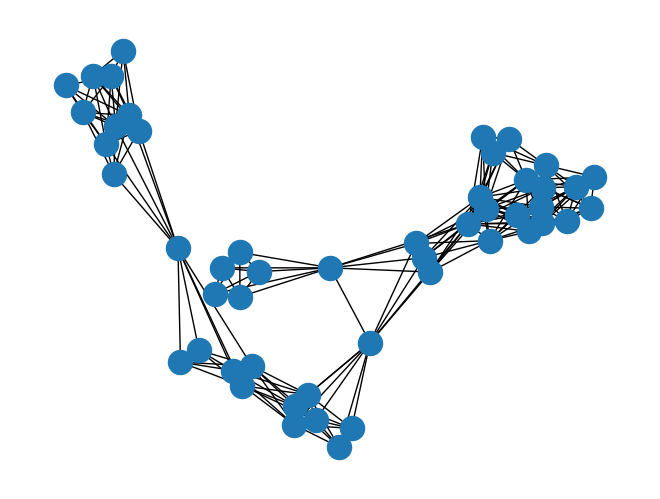

In [15]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [16]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(50, 64)


In [17]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean


f1i = np.mean(inclusion_score)
f1j = np.mean(inclusion_score)
wq = np.random.randint(100, size=(64,1))
wk = np.random.randint(100, size=(1,64))

f1i_wq = f1i*wq
f1j_wk = f1j*wk

wq_wk = int(np.matmul(f1j_wk, f1i_wq)) 

expo = np.exp(wq_wk)



C:\Users\debor\AppData\Local\Temp\ipykernel_50000\73126498.py:21: RuntimeWarning: overflow encountered in exp
  expo = np.exp(wq_wk)


### Sparse Attention

# Face Candidates

# Face Classifier

### TriConv

# Simplified Mesh

# Fonctions Loss

Récupération des points de l'espace de départ P

In [18]:
keys_input = list(graph._node.keys())
print(keys_input)
len(keys_input)  #return 5999

[(75.0252, -0.66553295, 3.8), (75.01418, -0.49935842, 16.7), (75.0, 0.0, 3.8), (75.00158, 0.16653232, 16.7), (75.0252, 0.66553295, 3.8), (75.03937, 0.8314692, 16.7), (75.10067, 1.3272538, 3.8), (75.12734, 1.4916434, 16.7), (75.22596, 1.9813722, 3.8), (75.26499, 2.1432736, 16.7), (75.40037, 2.6241417, 3.8), (75.45153, 2.7826276, 16.7), (75.62288, 3.2518802, 3.8), (75.68588, 3.4060426, 16.7), (75.892235, 3.8609922, 3.8), (75.96672, 4.0099483, 16.7), (76.20689, 4.4479885, 3.8), (76.29242, 4.590885, 16.7), (76.565025, 5.0095077, 3.8), (76.661125, 5.145526, 16.7), (76.96461, 5.5423326, 3.8), (77.07072, 5.670694, 16.7), (77.40334, 6.0434117, 3.8), (77.51886, 6.1633806, 16.7), (77.87872, 6.5098743, 3.8), (78.002975, 6.620764, 16.7), (78.388016, 6.9390492, 3.8), (78.5203, 7.0402236, 16.7), (78.92831, 7.328478, 3.8), (79.06786, 7.4193583, 16.7), (79.4965, 7.6759295, 3.8), (79.64253, 7.755995, 16.7), (80.08935, 7.9794145, 3.8), (80.24101, 8.048206, 16.7), (80.703445, 8.237194, 3.8), (80.859886, 

5999

Récupération des points de l'espace de départ Ps

In [19]:
keys_output = list(extended_graph)
print(keys_output)
len(keys_output)  #return: 50

[(91.42513, 0.33300498, -2.505017), (92.37709, 0.33300498, 1.0477394), (90.74569, 4.1574683, -1.3160838), (88.67287, 0.33300498, -7.2720723), (87.70355, 2.9401166, -7.6383314), (90.083786, -5.7970243, 0.593843), (82.27729, 8.672658, -3.4772909), (80.99978, 8.798424, -2.8634322), (79.23849, 8.237194, -0.016350994), (77.85172, 8.237194, -1.13933), (79.53464, 7.9794145, 1.4894849), (75.0, 8.672658, -6.4916434), (81.886826, 8.535009, 89.70452), (81.04928, 8.672658, 89.526115), (82.27729, 8.672658, 88.47729), (83.60757, 8.348472, 88.95029), (82.99811, 8.672658, 87.67674), (79.18599, 8.672658, 90.60188), (87.40501, -0.99710757, -8.605006), (77.49305, -6.5098743, 2.360639), (78.879944, -7.328478, 3.1854777), (76.407776, -7.328478, 0.13261138), (75.0, -6.9390492, 0.41198632), (75.0, -7.328478, -0.12830497), (75.0326, -3.2518802, 3.1779726), (84.582214, -0.33300498, -10.955316), (85.16452, 2.3044074, -10.190267), (75.0, -8.447791, -2.535284), (77.83952, -8.610001, -2.577679), (75.19, -1.8187612

50

Création de la liste normes entre chaque point

In [20]:
def compare_and_norm(keys_x, keys_y):
    normes_carre = []

    if len(keys_x) >= min(len(keys_x), len(keys_y)) and len(keys_y) >= min(len(keys_x), len(keys_y)):
        # Initialiser une liste pour stocker les normes au carré calculées

        # Iterer sur les 50 premiers points des deux listes
        for i in range(min(len(keys_x), len(keys_y))):
            # Convertir les tuples en arrays NumPy pour le calcul de la norme
            keys_x = np.array(keys_input[i])
            keys_y = np.array(keys_output[i])

            # Calculer la norme euclidienne au carré
            norme_carre = np.linalg.norm(keys_x - keys_y)**2

            # Ajouter la norme au carré à la liste
            normes_carre.append(norme_carre)

            # Afficher les informations
            # print(f"Point {i+1}: Keys Input: {keys_input[i]}, Keys Output: {keys_output[i]}, Norme: {norme}")
    else:
        print("Erreur : Les listes n'ont pas assez de points.")

    return normes_carre


In [21]:
normes_list = compare_and_norm(keys_input, keys_output)
print(normes_list)
len(normes_list)

[309.7081174070481, 547.1566728097969, 291.3856058674319, 761.5920997068897, 296.7497898821639, 529.6797493216618, 158.41782586662157, 470.6024202482695, 69.8002168047824, 362.06877159874784, 51.10961469790914, 572.7487111573319, 7446.734536261298, 5360.146345065965, 7234.163594053185, 5297.309142547252, 7099.276113882661, 5486.521956287557, 307.4687948240935, 342.1576981796534, 169.70390794395735, 443.8963415622711, 185.79900136454035, 471.5667455067305, 103.77919098366056, 856.4577163925605, 263.1284738556169, 622.2673786586711, 295.8953404173699, 1598.0706503337715, 2923.8045468205964, 777.140892308802, 6061.3944198717945, 4726.501655774424, 6989.154918351211, 5054.588154500583, 9066.174479954876, 5438.262415747216, 423.19849393157347, 1054.226662647212, 424.05901853636897, 918.6031087055198, 6963.795030016685, 5393.4104259037995, 7162.932490362087, 4888.0177406957955, 7199.905479793961, 2724.009384292891, 219.23389542941004, 5193.207331742218]


50